In [1]:
from typing import TypedDict

class State(TypedDict):
    graph_state: str

In [2]:
def node_1(state):
    print("----Node 1----")
    return {"graph_state": state['graph_state'] +"I am "}

def node_2(state):
    print("----Node 2----")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("----Node 3----")
    return {"graph_state": state['graph_state'] +" sad!"}

In [3]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    user_input = state['graph_state']

    if random.random() < 0.5:
        return "node_2"
    return "node_3"

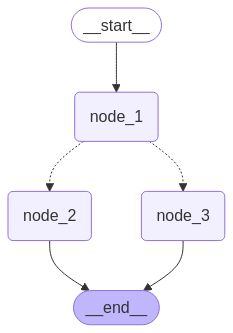

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# add
graph = builder.compile()

# view graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({'graph_state': 'Hi, I am Rohit.'})

----Node 1----
----Node 3----


{'graph_state': 'Hi, I am Rohit.I am  sad!'}

In [6]:
from pprint import pprint
from langchain_core.messages import AIMessage,HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.extend([HumanMessage(content=f"Yes that is right", name="Lance")])
messages.extend([AIMessage(content=f"Great would you like to learn about", name="Model")])
messages.extend([HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance")])

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes that is right
================================== Ai Message ==================================
Name: Model

Great would you like to learn about
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [7]:
from langchain_ollama import OllamaLLM

llm = OllamaLLM(model="llama3.2")

ollama_result = AIMessage(content=llm.invoke(messages), name="Model")
type(ollama_result)

langchain_core.messages.ai.AIMessage

In [8]:
ollama_result

AIMessage(content="Orcas, also known as killer whales, are indeed one of the most fascinating and intelligent ocean mammals.\n\nWhen it comes to seeing orcas in the United States, there are several locations that offer excellent opportunities for whale watching and viewing these magnificent creatures in their natural habitat. Here are some of the best places to see orcas in the US:\n\n1. **Puget Sound, Washington**: This is one of the most popular destinations for orca sightings in the US. Puget Sound is home to a large population of Southern Resident orcas, which can be seen on guided tours from Seattle and surrounding areas.\n2. **San Juan Islands, Washington**: Located off the coast of Washington state, the San Juan Islands are known for their abundant orca population. The islands offer a unique opportunity to see orcas in their natural habitat, with frequent sightings during the summer months.\n3. **Florida Keys**: The Florida Keys are an excellent spot for spotting bottlenose dolp

In [9]:
ollama_result.response_metadata

{}

In [10]:
def multiply(a: int, b: int) -> int:
    print("USING FUNCTION")
    return a * b

prompt = """
You are an AI that calls functions when needed.
If a user asks for a calculation, respond in JSON format like this:
{"function": "multiply", "args": {"a": 3, "b": 4}}

User: What is 3 times 7?
"""

tool_call = AIMessage(content=llm.invoke(prompt), name="Model")
tool_call

AIMessage(content='{"function": "multiply", "args": {"a": 3, "b": 7}}', additional_kwargs={}, response_metadata={}, name='Model')

In [11]:
import json

try:
    parsed = json.loads(tool_call.content)
    if parsed.get("function") == "multiply":
        result = multiply(**parsed["args"])
        print(f"Function Result: {result}")
    else:
        print("No function call detected.")
except json.JSONDecodeError:
    print("Invalid response format:", tool_call)

USING FUNCTION
Function Result: 21


In [12]:
from typing import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [13]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [14]:
from langgraph.graph import MessagesState

class State(MessagesState):
    pass

In [15]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='723cd001-6dc7-4a64-8b09-eaf70bb39890'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='f017780d-d5ad-417f-bb0d-cdb2d2a5ef68'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='f24c7b48-1102-4002-a7f7-a4f9c8b64976')]

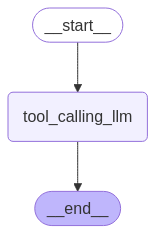

In [16]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph

def tool_calling_llm(state: dict):  
    messages = state.get("messages", [])
    
    if not messages:
        return {"messages": [AIMessage(content="No valid messages found", name="Model")]}

    user_message = messages[-1].content

    llama_prompt = f"""
    You are an AI that calls functions when needed. For General always introduce yourself in hi/hello based convertions as Chandler.
    If a user asks for a calculation, respond in JSON format like this:
    {{"function": "multiply", "args": {{"a": 3, "b": 4}}}}

    User: {user_message}
    AI:
    """
    
    tool_call = llm.invoke(llama_prompt)

    if isinstance(tool_call, str):
        tool_call = tool_call.strip()
        if tool_call:
            return {"messages": messages + [AIMessage(content=tool_call, name="Model")]}
    
    return {"messages": messages + [AIMessage(content="(No response generated)", name="Model")]}


builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
messages = graph.invoke({"messages": [HumanMessage(content="Hello!")]})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================
Name: Model

Hello! I'm Chandler, your friendly AI assistant. How can I help you today?


In [18]:
messages = graph.invoke({"messages": [HumanMessage(content="Multiply 29 and 39!")]})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 29 and 39!
================================== Ai Message ==================================
Name: Model

Hello! I'm Chandler. How can I assist you today? You'd like to multiply 29 and 39, right?

{"function": "multiply", "args": {"a": 29, "b": 39}}
